<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/COMPAS_data_inspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
import os

# Specify the directory path
directory_path = '//Users/mirthedankloff/Documents/XAI_Bias_Error/COMPAS'

# Traverse the directory and print the names of all files
for dirname, _, filenames in os.walk(directory_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Load cleaned Compas data

In [115]:
#compas_s = pd.read_csv("/content/final_preprocessed_compas(2).csv")
#ofercompas = pd.read_csv("/content/propublica_data_for_fairml.csv")
#originalcompas = pd.read_csv("/content/compas-scores-two-years-violent.csv")
#cox_violent_filt = pd.read_csv('/content/cox-violent-parsed_filt.csv')
compas_2 = pd.read_csv('/content/cleaned_compas_data.csv')

In [116]:
compas_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       7214 non-null   int64 
 1   sex                      7214 non-null   object
 2   age                      7214 non-null   int64 
 3   age_cat                  7214 non-null   object
 4   race                     7214 non-null   object
 5   decile_score             7214 non-null   int64 
 6   priors_count             7214 non-null   int64 
 7   is_recid                 7214 non-null   int64 
 8   is_violent_recid         7214 non-null   int64 
 9   score_text               7214 non-null   object
 10  v_decile_score           7214 non-null   int64 
 11  priors_count.1           7214 non-null   int64 
 12  event                    7214 non-null   int64 
 13  two_year_recid           7214 non-null   int64 
 14  sex_Female               7214 non-null  

In [117]:
#Check if is_recid and two year recid are the same
if (compas_2['is_recid'] == compas_2['two_year_recid']).any():
    print("same")
else:
    print("not same")

same


In [118]:
#Select Features
X = compas_2.drop(['two_year_recid', 'id', 'score_text', 'v_decile_score', 'priors_count.1', 'is_recid', 'is_violent_recid', 'sex', 'age_cat', 'race', 'event', 'age_cat_Greater than 45', 'age_cat_25 - 45', 'age_cat_Less than 25'],axis=1)
Y = compas_2['two_year_recid']


In [119]:
Y.shape[0]

7214

In [120]:
X.shape[0]

7214

# Train Random Forest Classifier

In [121]:
#Train model

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = True, stratify = Y)

model = RandomForestClassifier()
model.fit(X_train, Y_train)

#predictions
Yhat = model.predict(X_test)
len(Yhat)


2165

# Collect the errors

In [122]:
#Create data frame to contain the predicted and true classes - converting y_hat np to df
predictions = pd.DataFrame()
predictions['predicted_class'] = Yhat.tolist()
predictions = predictions.set_index(X_test.index)
predictions['true_class'] = Y_test

#calculating the errors with the absolute value
predictions['errors'] = abs(predictions['predicted_class'] - predictions['true_class'])

#adding predictions to the test data
entire_dataset = X_test.merge(predictions, how= 'outer', left_index = True, right_index = True)

errors = entire_dataset['errors']
df_out = entire_dataset.drop(['predicted_class', 'true_class', 'errors'], axis=1)
entire_dataset[entire_dataset['errors']==1]

#accuracy
accuracy = accuracy_score(predictions['true_class'], predictions['predicted_class'])
print(f"Accuracy: {accuracy:.4f}")

#confusion matrix
cm = confusion_matrix(predictions['true_class'], predictions['predicted_class'])
print(cm)


Accuracy: 0.6360
[[812 377]
 [411 565]]


Selecting 4 labels (FP, FN, TP, TN)

In [123]:
def get_error_type(row):
    true_class = row['true_class']
    predicted_class = row['predicted_class']

    if true_class == predicted_class and true_class == 1:
        row['TP'] = 1
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 0
    elif true_class == predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 1
        row['FN'] = 0
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 1:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 1
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 1

    return row

#apply function to rows in data
entire_dataset = entire_dataset.apply(get_error_type, axis=1)

#print(data_pred.columns)
print(entire_dataset)

      age  decile_score  priors_count  sex_Female  sex_Male  \
1050   36             3             2           0         1   
3506   56             1             0           0         1   
6374   30             2             0           0         1   
3349   20             5             0           0         1   
5831   39             1             0           0         1   
...   ...           ...           ...         ...       ...   
2766   30             9             9           1         0   
4914   21             8             0           0         1   
7183   24             6             0           1         0   
1738   31             3             0           0         1   
7108   33             7             4           0         1   

      race_African-American  race_Asian  race_Caucasian  race_Hispanic  \
1050                      1           0               0              0   
3506                      0           0               1              0   
6374                 

In [124]:
#Check if there are any FP/FN
if (entire_dataset['FP'] == 1).any():
    print("There's at least one occurrence of 1 in the column.")
else:
    print("There's no occurrence of 1 in the column.")

There's at least one occurrence of 1 in the column.


# add categorical for error type to make visualizations

In [125]:
# Extract dummy variables for error labels
error_type = entire_dataset[['TP', 'FP', 'FN', 'TN']]

# Convert 'Error_type' column to categorical
entire_dataset['Error_Type'] = error_type.idxmax(axis=1).astype('category')

entire_dataset = pd.merge(entire_dataset, compas_2[['sex', 'race']], left_index=True, right_index=True)


In [126]:
#change objects to categories
for col in ['sex', 'race']:
    entire_dataset[col] = entire_dataset[col].astype('category')

entire_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2165 entries, 1050 to 7108
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   age                    2165 non-null   int64   
 1   decile_score           2165 non-null   int64   
 2   priors_count           2165 non-null   int64   
 3   sex_Female             2165 non-null   int64   
 4   sex_Male               2165 non-null   int64   
 5   race_African-American  2165 non-null   int64   
 6   race_Asian             2165 non-null   int64   
 7   race_Caucasian         2165 non-null   int64   
 8   race_Hispanic          2165 non-null   int64   
 9   race_Native American   2165 non-null   int64   
 10  race_Other             2165 non-null   int64   
 11  predicted_class        2165 non-null   int64   
 12  true_class             2165 non-null   int64   
 13  errors                 2165 non-null   int64   
 14  TP                     2165 non-null 


# Barchart 4 labels (FP, FN, TP, TN)

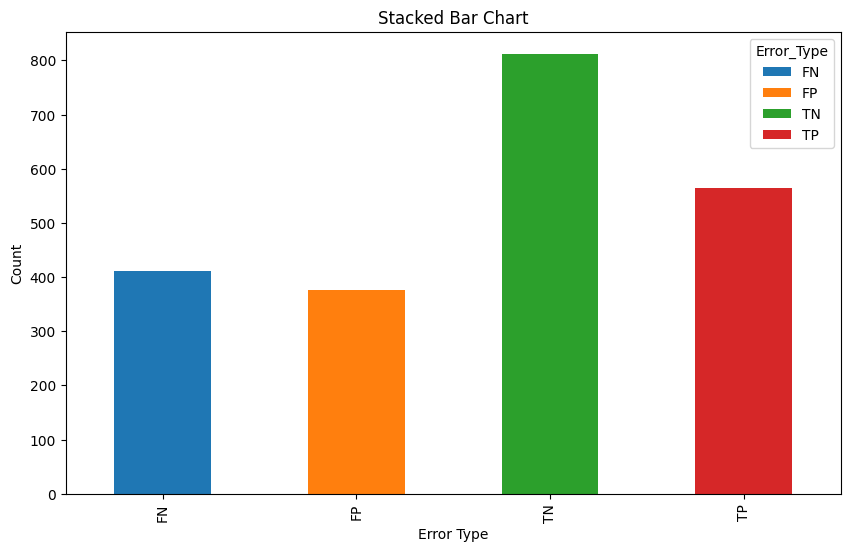

In [127]:
errors_df = entire_dataset[['TP', 'FP', 'FN', 'TN']]

# Melt the DataFrame for easy plotting
melted_df = pd.melt(errors_df, var_name='Error_Type', value_name='Count')

# Pivot the DataFrame for stacked bar chart
pivot_df = melted_df.pivot_table(index='Error_Type', columns='Error_Type', values='Count', aggfunc='sum', fill_value=0)

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.xlabel('Error Type')
plt.ylabel('Count')
plt.title('Stacked Bar Chart')

# Show the plot
plt.show()


# Barchart error labels per demographic group

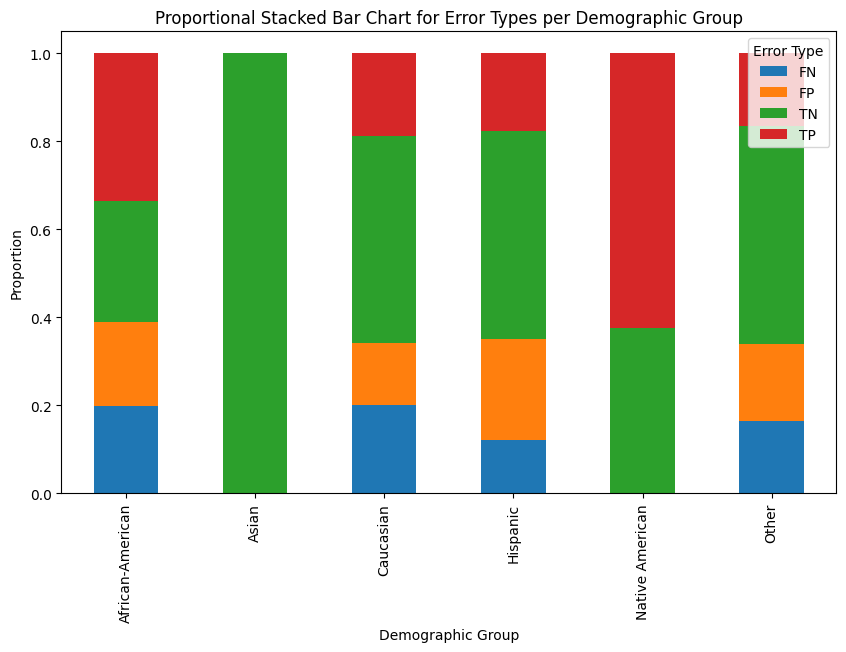

In [128]:
#Group data by 'race' and 'Error_Type' and count occurrences
race_error_counts = entire_dataset.groupby(['race', 'Error_Type']).size().unstack(fill_value=0)

# Normalize counts along the y-axis
race_error_proportions = race_error_counts.div(race_error_counts.sum(axis=1), axis=0)

# Plot the proportional stacked bar chart
race_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Proportional Stacked Bar Chart for Error Types per Demographic Group')
plt.xlabel('Demographic Group')
plt.ylabel('Proportion')
plt.legend(title='Error Type', loc='upper right')

# Show the plot
plt.show()



# Barchart error labels per gender

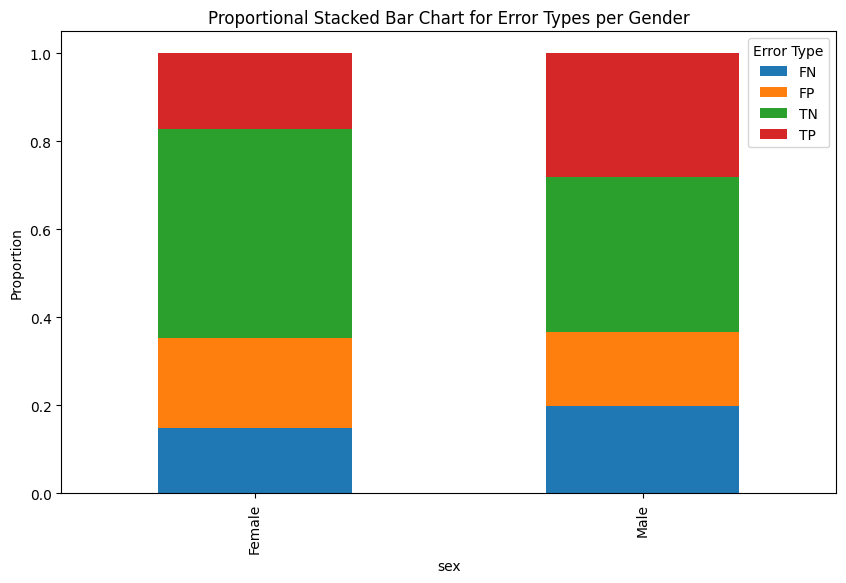

In [129]:
#Group data by 'race' and 'Error_Type' and count occurrences
sex_error_counts = entire_dataset.groupby(['sex', 'Error_Type']).size().unstack(fill_value=0)

# Normalize counts along the y-axis
sex_error_proportions = sex_error_counts.div(sex_error_counts.sum(axis=1), axis=0)

# Plot the proportional stacked bar chart
sex_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Proportional Stacked Bar Chart for Error Types per Gender')
plt.xlabel('sex')
plt.ylabel('Proportion')
plt.legend(title='Error Type', loc='upper right')

# Show the plot
plt.show()

# Bar Chart Error labels per Age

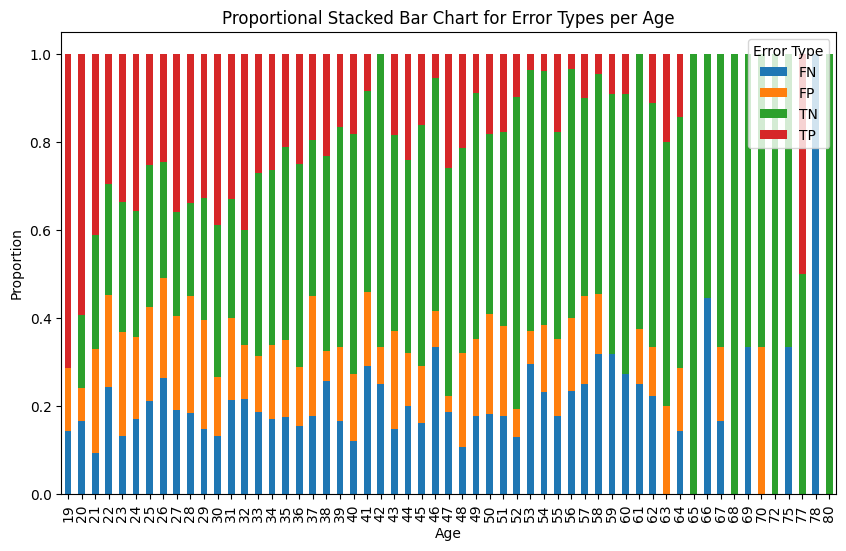

In [130]:
# Group data by 'age' and 'Error_Type' and count occurrences
age_error_counts = entire_dataset.groupby(['age', 'Error_Type']).size().unstack(fill_value=0)

# Normalize counts along the y-axis
age_error_proportions = age_error_counts.div(age_error_counts.sum(axis=1), axis=0)

# Plot the proportional stacked bar chart
age_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Proportional Stacked Bar Chart for Error Types per Age')
plt.xlabel('Age')
plt.ylabel('Proportion')
plt.legend(title='Error Type', loc='upper right')

# Show the plot
plt.show()


# Boxplot error label per age with jitter

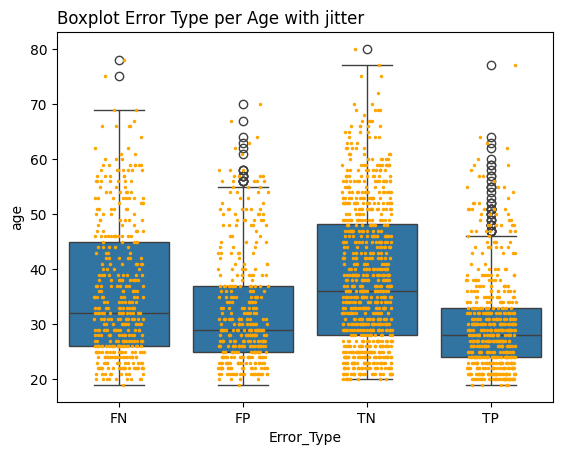

In [131]:
# boxplot
ax = sns.boxplot(x='Error_Type', y='age', data=entire_dataset)
# add stripplot
ax = sns.stripplot(x='Error_Type', y='age', data=entire_dataset, color="orange", jitter=0.2, size=2.5)

# add title
plt.title("Boxplot Error Type per Age with jitter", loc="left")

# show the graph
plt.show()

# Violinplot

In [132]:
#entire_dataset.info()
entire_dataset.head()

,age,decile_score,priors_count,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,...,predicted_class,true_class,errors,TP,TN,FN,FP,Error_Type,sex,race
1050,36,3,2,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,TN,Male,African-American
3506,56,1,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,TN,Male,Caucasian
6374,30,2,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,TN,Male,Caucasian
3349,20,5,0,0,1,1,0,0,0,0,...,1,1,0,1,0,0,0,TP,Male,African-American
5831,39,1,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,TN,Male,Caucasian


Violin plot as combination of boxplot and kernel density plot.

The width represents the densitiy of datapoints at a certian value. Middle bar inside violin represents the interquartile range.


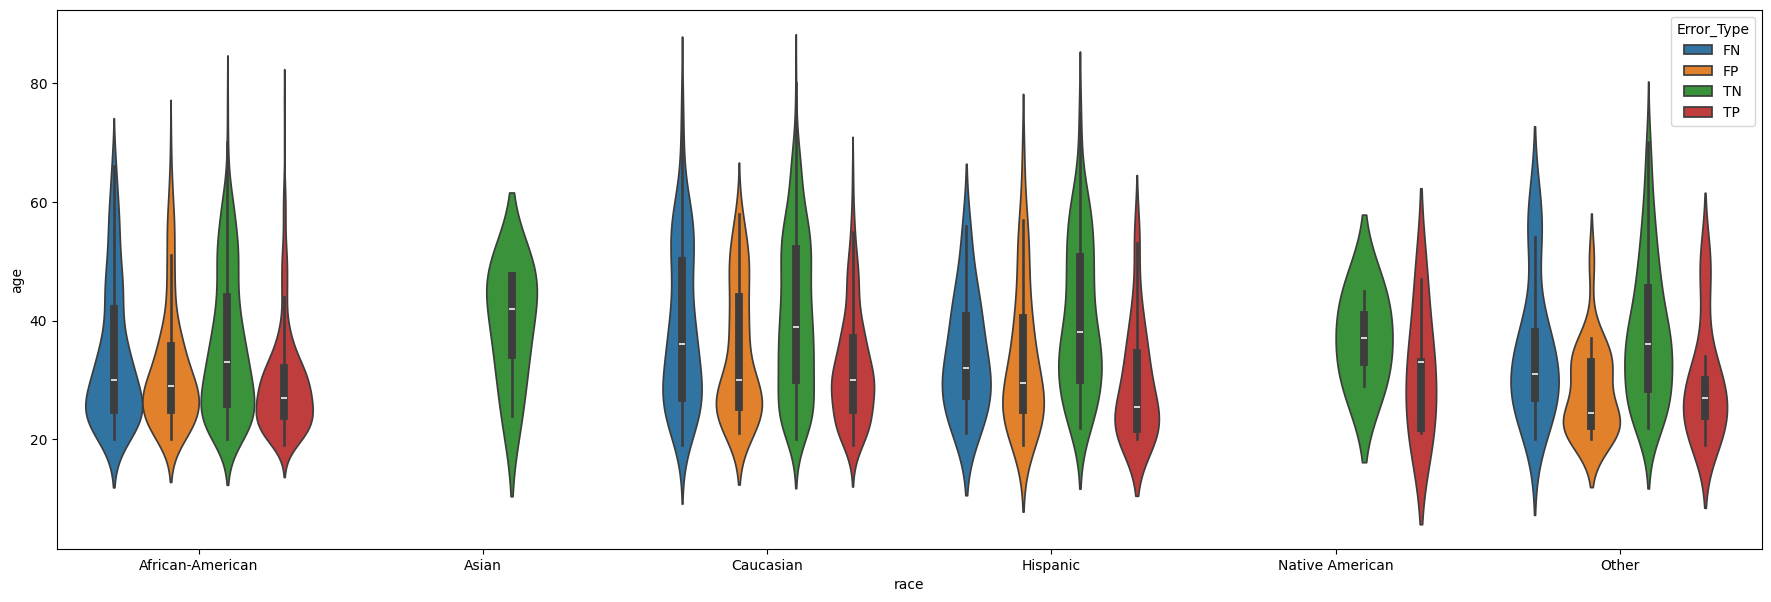

In [133]:
#sns.violinplot(x="Error_Type", y="age", data=entire_dataset)
#plt.show()

#sns.violinplot(x="Error_Type", y="age_cat", data=entire_dataset)
#plt.show()

#plt.figure(figsize=(3, 15))

#sns.violinplot(x="age", y="race", hue = "Error_Type", data=entire_dataset)
#plt.show()

#sns.violinplot(x="Error_Type", y="sex", data=entire_dataset)
#plt.show()

plt.figure(figsize=(22, 7))

sns.violinplot(x="race", y="age", hue = "Error_Type", data=entire_dataset)
plt.show()


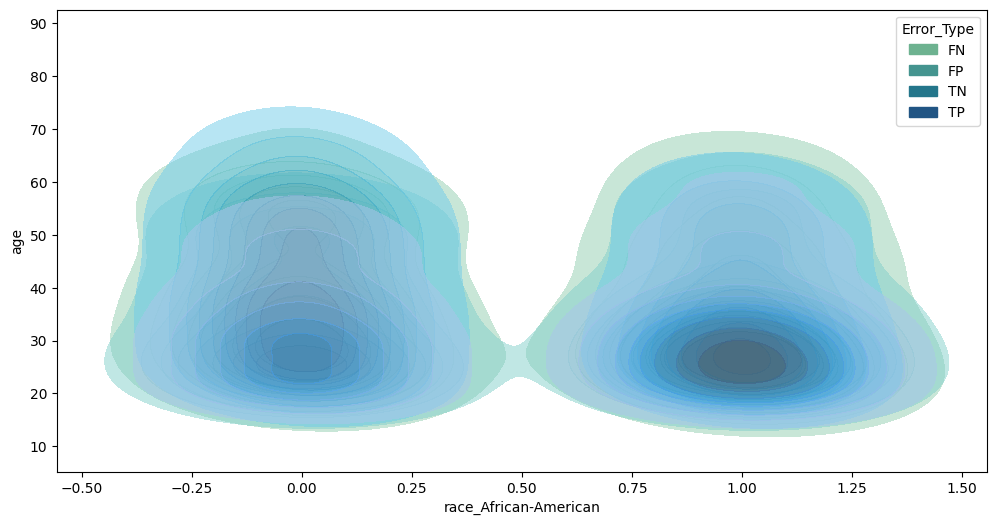

In [134]:
#race_categories = ['race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other']
#entire_dataset['race_cat'] = pd.Categorical(entire_dataset['race'], categories=race_categories, ordered=True)

plt.figure(figsize=(12, 6))

sns.kdeplot(data=entire_dataset, x="race_African-American", y="age", hue="Error_Type", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0)

plt.show()


In [135]:
entire_dataset.info()
entire_dataset.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2165 entries, 1050 to 7108
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   age                    2165 non-null   int64   
 1   decile_score           2165 non-null   int64   
 2   priors_count           2165 non-null   int64   
 3   sex_Female             2165 non-null   int64   
 4   sex_Male               2165 non-null   int64   
 5   race_African-American  2165 non-null   int64   
 6   race_Asian             2165 non-null   int64   
 7   race_Caucasian         2165 non-null   int64   
 8   race_Hispanic          2165 non-null   int64   
 9   race_Native American   2165 non-null   int64   
 10  race_Other             2165 non-null   int64   
 11  predicted_class        2165 non-null   int64   
 12  true_class             2165 non-null   int64   
 13  errors                 2165 non-null   int64   
 14  TP                     2165 non-null 

,age,decile_score,priors_count,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,...,predicted_class,true_class,errors,TP,TN,FN,FP,Error_Type,sex,race
1050,36,3,2,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,TN,Male,African-American
3506,56,1,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,TN,Male,Caucasian
6374,30,2,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,TN,Male,Caucasian
3349,20,5,0,0,1,1,0,0,0,0,...,1,1,0,1,0,0,0,TP,Male,African-American
5831,39,1,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,TN,Male,Caucasian


# PCA

**Without scaled features**

Each point represents an observation in entire_dataset. Points closer together have similar patterns across features. Culsters may indicate subgroups. Outliers deviate from the general pattern

Explained Variance Ratio: PC1 = 0.79, PC2 = 0.18


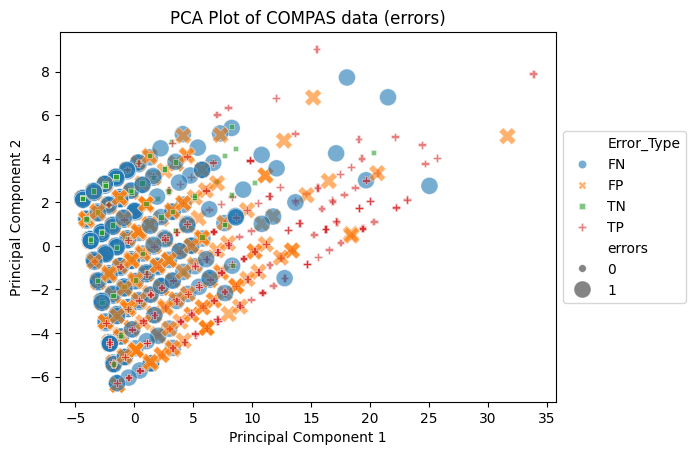

In [136]:
def pca_plot(data, title, alpha):
  #extracts the features for PCA, excluding columns that are not part of the features used for PCA. Other_features are used later for additional information in the plot
    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'age', 'race'], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'age', 'race']]
    df = pd.DataFrame(pca_features)

    #applies PCA with 2 components to the features and creates a DataFrame with the resulting principal components
    pca = pd.DataFrame(PCA(n_components=2).fit_transform(df), index = df.index)
    temp_dataset = pca.join(other_features, how = 'left')
    temp_dataset.rename( columns={0 :'Principal Component 1'}, inplace=True )
    temp_dataset.rename( columns={1 :'Principal Component 2'}, inplace=True )

    scatterplot = sns.scatterplot(data=temp_dataset, x='Principal Component 1', y='Principal Component 2', alpha=alpha, hue="Error_Type", size='errors', sizes=(150, 30), palette="tab10", style = "Error_Type")
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = PCA(n_components=2).fit(df).explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

pca_plot(entire_dataset, 'PCA Plot of COMPAS data (errors)', 0.6)



**With Scaled features**

Explained Variance Ratio: PC1 = 0.23, PC2 = 0.18


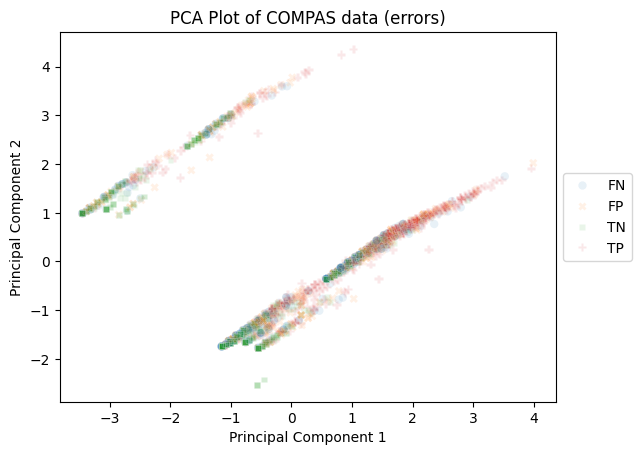

In [221]:
def pca_plot(data, title, alpha):

    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'age', 'race'], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'age', 'race']]

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pca_features)

    # Apply PCA with 2 components to the scaled features and create a DataFrame with the resulting principal components
    pca_result = PCA(n_components=2).fit_transform(scaled_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index)
    temp_dataset = pca_df.join(other_features, how='left')
    temp_dataset.rename(columns={0: 'Principal Component 1', 1: 'Principal Component 2'}, inplace=True)

    scatterplot = sns.scatterplot(data=temp_dataset, x='Principal Component 1', y='Principal Component 2', alpha=alpha, hue="Error_Type",
                                  #size='errors', sizes=(150, 30),
                                  palette="tab10", style="Error_Type")
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = PCA(n_components=2).fit(scaled_features).explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

# Example usage
pca_plot(entire_dataset, 'PCA Plot of COMPAS data (errors)', 0.1)

# SHAP

In [138]:
!pip install shap
import shap

## SHAP WITHOUT error labels added

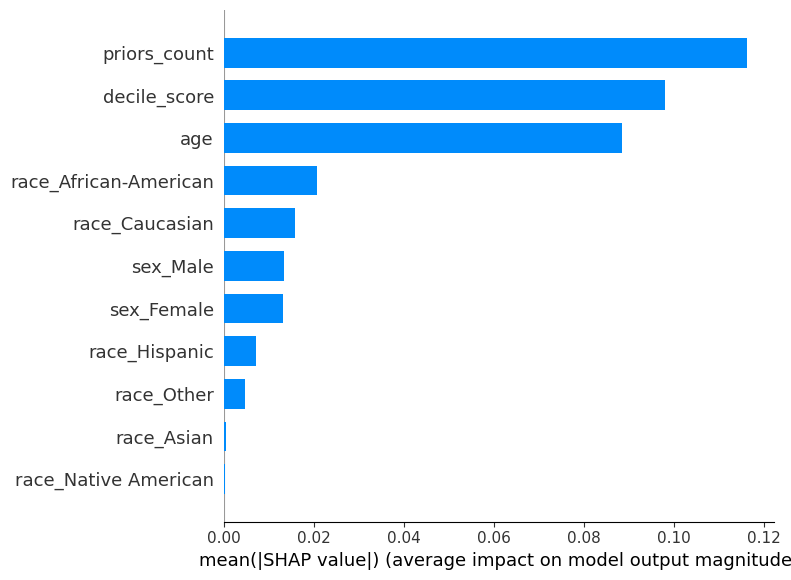

In [224]:
explainer = shap.TreeExplainer(model, approximate=True)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[0], X_test, plot_type = "bar")

#create a for loop where for every instance in X_test you take the
# for i in entire_dataset
### i_feature_values = remove error label from i
### shap_values = explainer.shap_values(i_feature_values)
### new_row = add_column(i, shap_values)
### data_with_shap_values = add_row(data_with_shap_values, new_row)

In [228]:
print(shap_values[0][0])

[ 9.74751166e-02  1.24719801e-01  7.10975802e-02  9.96182861e-03
  1.18138716e-02 -2.54457984e-03  3.46308525e-06  9.32504731e-03
 -2.18059085e-04 -3.63067978e-04  3.37665153e-03]


In [234]:
test_shap = X_test.apply(explainer.shap_values, axis=1)
#make a function like error label - add 11 columnnames eg shap_age- check per row - append it to dataset

1050    [[0.09747511655210606, 0.12471980104277239, 0....
3506    [[0.14867565556124926, 0.16927357765862075, 0....
6374    [[-0.05127453902143112, 0.024311032392255214, ...
3349    [[-0.3823688074727399, -0.12430036044613535, 0...
5831    [[-0.01614841953296289, 0.0801495867793304, 0....
                              ...                        
2766    [[-0.0426497289575795, -0.15864519337240485, -...
4914    [[-0.20940546097229892, -0.25097702167227937, ...
7183    [[-0.011514799237249046, -0.0698740493403152, ...
1738    [[0.0968916286683558, 0.03695219535816921, 0.1...
7108    [[-0.03189267196446203, -0.07919600061164118, ...
Length: 2165, dtype: object

## SHAP with error labels added

In [216]:
#shap for 4 groups with different error label
#for loop for each row


# Train NEW MODEL with error labels
Y_new_model = entire_dataset['true_class']
#Y_new_model.shape[0]
Z = entire_dataset.drop(['sex','race', 'Error_Type', 'true_class'], axis =1)

Z_train, Z_test, Y_train_new, Y_test_new = train_test_split(Z, Y_new_model, test_size=0.3, shuffle=True, stratify=Y_new_model)

model2 = RandomForestClassifier()
model2.fit(Z_train, Y_train_new)

# Make predictions
Yhat_new = model2.predict(Z_test)
len(Yhat_new)



650

In [220]:
#construct explainer object
error_explainer = shap.TreeExplainer(model2, approximate=True)

#although overfitting doesnt apply to SHAP, its considered best practice to use the training data for the explainer and explanations for new (test)data.
#shap_values2 = explainer2.shap_values(Z_test)

error_shap_values = error_explainer.error_shap_values(Z_test)

#Error_shap_values = Error_Explainer.Error_shap_values(Z_test)
shap.summary_plot(Error_shap_values[1], Z_test, plot_type="bar")

AttributeError: 'TreeExplainer' object has no attribute 'error_shap_values'

In [214]:
# Plot waterfall plot for single instance
#shap.plots.waterfall(shap_values2[1][0])

print(shap_values2.values)

AttributeError: 'list' object has no attribute 'values'